## Inverse Cooking: Recipe Generation from Food Images

In [45]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
import os
from args import get_parser
import pickle
from model import get_model
from torchvision import transforms
from utils.output_utils import prepare_output
from PIL import Image
import time

Set ```data_dir``` to the path including vocabularies and model checkpoint

In [46]:
data_dir = '../data'

In [47]:
# code will run in gpu if available and if the flag is set to True, else it will run on cpu
use_gpu = False
device = torch.device('cuda' if torch.cuda.is_available() and use_gpu else 'cpu')
map_loc = None if torch.cuda.is_available() and use_gpu else 'cpu'

In [48]:
# code below was used to save vocab files so that they can be loaded without Vocabulary class
#ingrs_vocab = pickle.load(open(os.path.join(data_dir, 'final_recipe1m_vocab_ingrs.pkl'), 'rb'))
#ingrs_vocab = [min(w, key=len) if not isinstance(w, str) else w for w in ingrs_vocab.idx2word.values()]
#vocab = pickle.load(open(os.path.join(data_dir, 'final_recipe1m_vocab_toks.pkl'), 'rb')).idx2word
#pickle.dump(ingrs_vocab, open('../demo/ingr_vocab.pkl', 'wb'))
#pickle.dump(vocab, open('../demo/instr_vocab.pkl', 'wb'))

ingrs_vocab = pickle.load(open(os.path.join(data_dir, 'ingr_vocab.pkl'), 'rb'))
vocab = pickle.load(open(os.path.join(data_dir, 'instr_vocab.pkl'), 'rb'))

ingr_vocab_size = len(ingrs_vocab)
instrs_vocab_size = len(vocab)
output_dim = instrs_vocab_size

In [49]:
print (instrs_vocab_size, ingr_vocab_size)

23231 1488


In [50]:
t = time.time()
import sys; sys.argv=['']; del sys
args = get_parser()
args.maxseqlen = 15
args.ingrs_only=False
model = get_model(args, ingr_vocab_size, instrs_vocab_size)
# Load the trained model parameters
model_path = os.path.join(data_dir, 'modelbest.ckpt')
model.load_state_dict(torch.load(model_path, map_location=map_loc))
model.to(device)
model.eval()
model.ingrs_only = False
model.recipe_only = False
print ('loaded model')
print ("Elapsed time:", time.time() -t)


/opt/anaconda3/envs/inversecooking/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/inversecooking/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/opt/anaconda3/envs/inversecooking/lib/python3.12/site-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
/opt/anaconda3/envs/inversecooking/lib/python3.12/site-packages/torch/nn/_reduction.py:51: UserWarning

loaded model
Elapsed time: 1.0155813694000244


In [51]:
transf_list_batch = []
transf_list_batch.append(transforms.ToTensor())
transf_list_batch.append(transforms.Normalize((0.485, 0.456, 0.406), 
                                              (0.229, 0.224, 0.225)))
to_input_transf = transforms.Compose(transf_list_batch)

In [52]:
greedy = [True, False, False, False]
beam = [-1, -1, -1, -1]
temperature = 1.0
numgens = len(greedy)

Set ```use_urls = True``` to get recipes for images in ```demo_urls```. 

You can also set ```use_urls = False``` and get recipes for images in the path in ```data_dir/test_imgs```.

In [53]:
# Install requests if not already installed
import sys
import subprocess
subprocess.check_call([sys.executable, "-m", "pip", "install", "requests"])


0

In [54]:
import requests
from io import BytesIO
import random
from collections import Counter
use_urls = False # set to true to load images from demo_urls instead of those in test_imgs folder
show_anyways = False #if True, it will show the recipe even if it's not valid
image_folder = os.path.join(data_dir, 'demo_imgs')

if not use_urls:
    demo_imgs = os.listdir(image_folder)
    random.shuffle(demo_imgs)

demo_urls = ['https://food.fnr.sndimg.com/content/dam/images/food/fullset/2013/12/9/0/FNK_Cheesecake_s4x3.jpg.rend.hgtvcom.826.620.suffix/1387411272847.jpeg',
            'https://www.196flavors.com/wp-content/uploads/2014/10/california-roll-3-FP.jpg']

demo_files = demo_urls if use_urls else demo_imgs

In [55]:
from modules.multihead_attention import MultiheadAttention
import inspect, os

print(MultiheadAttention)
print(os.path.abspath(inspect.getsourcefile(MultiheadAttention)))
print(inspect.getsource(MultiheadAttention.forward))

<class 'modules.multihead_attention.MultiheadAttention'>
/Users/liming/Documents/inversecooking-master/src/modules/multihead_attention.py
def mh_forward(self, query, key, value, mask_future_timesteps=False,
               key_padding_mask=None, incremental_state=None,
               need_weights=True, static_kv=False):
    """
    A simplified version of MultiheadAttention.forward:
    - Completely ignores key_padding_mask, no longer calls masked_fill
    - Retains the original attention calculation logic, sufficient for demo recipe generation
    """
    qkv_same = query.data_ptr() == key.data_ptr() == value.data_ptr()
    kv_same = key.data_ptr() == value.data_ptr()

    tgt_len, bsz, embed_dim = query.size()
    assert embed_dim == self.embed_dim
    assert list(query.size()) == [tgt_len, bsz, embed_dim]
    assert key.size() == value.size()

    # Handle incremental_state (cache key, value)
    if incremental_state is not None:
        saved_state = self._get_input_buffer(increment

In [56]:
import torch
import torch.nn.functional as F
from modules.multihead_attention import MultiheadAttention

def mh_forward(self, query, key, value, mask_future_timesteps=False,
               key_padding_mask=None, incremental_state=None,
               need_weights=True, static_kv=False):
    """
    A simplified version of MultiheadAttention.forward:
    - Completely ignores key_padding_mask, no longer calls masked_fill
    - Retains the original attention calculation logic, sufficient for demo recipe generation
    """
    qkv_same = query.data_ptr() == key.data_ptr() == value.data_ptr()
    kv_same = key.data_ptr() == value.data_ptr()

    tgt_len, bsz, embed_dim = query.size()
    assert embed_dim == self.embed_dim
    assert list(query.size()) == [tgt_len, bsz, embed_dim]
    assert key.size() == value.size()

    # Handle incremental_state (cache key, value)
    if incremental_state is not None:
        saved_state = self._get_input_buffer(incremental_state)
        if 'prev_key' in saved_state:
            if static_kv:
                assert kv_same and not qkv_same
                key = value = None
    else:
        saved_state = None

    # Calculate q, k, v
    if qkv_same:
        q, k, v = self.in_proj_qkv(query)
    elif kv_same:
        q = self.in_proj_q(query)
        if key is None:
            assert value is None
            k = v = q.new(0)
        else:
            k, v = self.in_proj_kv(key)
    else:
        q = self.in_proj_q(query)
        k = self.in_proj_k(key)
        v = self.in_proj_v(value)

    q *= self.scaling

    # If cached, concatenate previous key / value
    if saved_state is not None:
        if 'prev_key' in saved_state:
            k = torch.cat((saved_state['prev_key'], k), dim=0)
        if 'prev_value' in saved_state:
            v = torch.cat((saved_state['prev_value'], v), dim=0)
        saved_state['prev_key'] = k
        saved_state['prev_value'] = v
        self._set_input_buffer(incremental_state, saved_state)

    src_len = k.size(0)

    # reshape to multi-head form
    q = q.contiguous().view(tgt_len, bsz * self.num_heads, self.head_dim).transpose(0, 1)
    k = k.contiguous().view(src_len, bsz * self.num_heads, self.head_dim).transpose(0, 1)
    v = v.contiguous().view(src_len, bsz * self.num_heads, self.head_dim).transpose(0, 1)

    # Dot product attention
    attn_weights = torch.bmm(q, k.transpose(1, 2))
    assert list(attn_weights.size()) == [bsz * self.num_heads, tgt_len, src_len]

    # Future mask (decoder autoregressive)
    if mask_future_timesteps and incremental_state is None:
        assert query.size() == key.size(), \
            'mask_future_timesteps only applies to self-attention'
        attn_weights += self.buffered_mask(attn_weights).unsqueeze(0)

    
    # if key_padding_mask is not None:
    #     ...

    # Softmax + dropout
    attn_weights = F.softmax(attn_weights.float(), dim=-1).type_as(attn_weights)
    attn_weights = F.dropout(attn_weights, p=self.dropout, training=self.training)

    # Weighted sum to get output
    attn = torch.bmm(attn_weights, v)
    assert list(attn.size()) == [bsz * self.num_heads, tgt_len, self.head_dim]
    attn = attn.transpose(0, 1).contiguous().view(tgt_len, bsz, embed_dim)
    attn = self.out_proj(attn)

    # Average all heads 
    if need_weights:
        attn_w = attn_weights.view(bsz, self.num_heads, tgt_len, src_len)
        attn_w = attn_w.sum(dim=1) / self.num_heads
    else:
        attn_w = None

    return attn, attn_w


MultiheadAttention.forward = mh_forward

print("MultiheadAttention.forward has been replaced with a simplified version at runtime.")

MultiheadAttention.forward has been replaced with a simplified version at runtime.


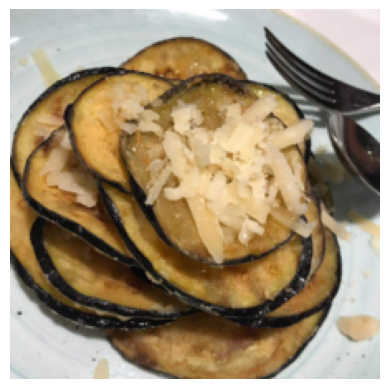

RECIPE 1

Title: Grilled eggplant and zucchini

Ingredients:
zucchini, oil, salt, eggplant, pepper

Instructions:
-Preheat grill to medium-high.
-Brush eggplant slices with oil and season with salt and pepper.
-Grill, turning once, until tender and lightly charred, about 10 minutes.
-Transfer to a platter and let cool.
-Cut into 1/2-inch slices.
-Serve with a drizzle of olive oil.
RECIPE 2

Title: Fried eggplant

Ingredients:
zucchini, oil, salt, eggplant, pepper

Instructions:
-Heat pan to 400 degrees f.
-Add oil to pan.
-Slice eggplant into 1/4 slices; place in oil and cook over high heat till golden brown, turning once.
-Remove slices on paper towels.
-Drain all but 2 tbs oil from pan and place on paper towels to absorb oil.
-Season with salt and pepper to taste.
-Drizzle remaining oil over eggplant slices and toss lightly.
-Return the slices to pan, spray side with oil spray to prevent sticking.
-Cook until browned, about 5 min on each side.
RECIPE 2

Title: Fried eggplant

Ingredi

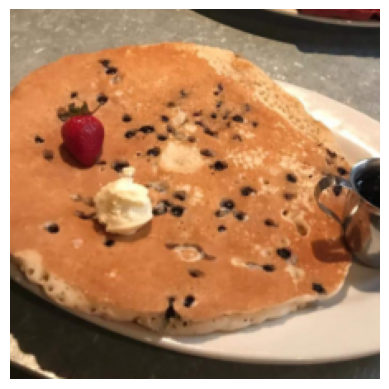

RECIPE 1

Title: Easy pancakes

Ingredients:
sugar, flour, egg, salt, butter, baking_powder, milk, oil

Instructions:
-Mix all ingredients together.
-Heat skillet and pour 1/4 cup of batter onto skillet.
-Cook until bubbles form on top.
-Flip and cook until golden brown.
RECIPE 2

Title: Pancakes

Ingredients:
sugar, flour, egg, salt, butter, baking_powder, milk, oil

Instructions:
-Beat together eggs, milk, butter and oil.
-Add dry ingredients.
-Stir in chopped green onions.
-Heat griddle or skillet to 375 degrees.
-Drop by heaping teaspoonfuls onto greased griddle.
-Cook until browned.
-Sprinkle with powdered sugar.
-Serve with syrup.
RECIPE 2

Title: Pancakes

Ingredients:
sugar, flour, egg, salt, butter, baking_powder, milk, oil

Instructions:
-Beat together eggs, milk, butter and oil.
-Add dry ingredients.
-Stir in chopped green onions.
-Heat griddle or skillet to 375 degrees.
-Drop by heaping teaspoonfuls onto greased griddle.
-Cook until browned.
-Sprinkle with powdered sugar.
-

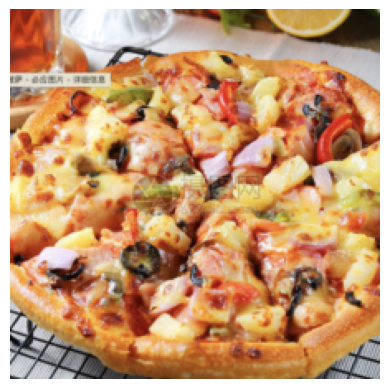

RECIPE 1

Title: Pizza with caramelized onions and olives

Ingredients:
cheese, onion, olive, pizza_dough, pepper, oil, pizza_crust, salt, tomato

Instructions:
-Preheat oven to 450 degrees f.
-Roll out pizza dough on a lightly floured surface to a 12-inch round.
-Transfer to a baking sheet.
-Brush dough with olive oil.
-Sprinkle with salt and pepper.
-Top with onions, tomatoes, olives, and cheese.
-Bake for 10 minutes.
-Remove from oven and let stand for 5 minutes before serving.
RECIPE 2

Title: Pizza

Ingredients:
cheese, onion, olive, pizza_dough, pepper, oil, pizza_crust, salt, tomato

Instructions:
-Preheat oven to 450 degrees f (230 degrees c).
-Heat olive oil in a skillet over medium heat; saute chopped onion until soft.
-Spread onion over pizza crust.
-Top with tomato slices, olives, and feta cheese.
-Season with salt and pepper.
-Bake in preheated oven for 10 minutes.
RECIPE 2

Title: Pizza

Ingredients:
cheese, onion, olive, pizza_dough, pepper, oil, pizza_crust, salt, tomat

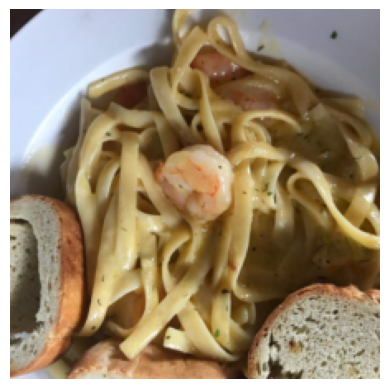

RECIPE 1

Title: Shrimp scampi

Ingredients:
shrimp, pepper, butter, clove, oil, salt, pasta, parsley

Instructions:
-Heat olive oil in a large skillet over medium heat.
-Cook and stir garlic in hot oil until fragrant, about 1 minute.
-Stir shrimp into garlic; cook and stir until shrimp are pink and opaque, about 3 minutes.
-Season with salt and pepper.
-Stir butter into shrimp mixture until melted and sauce is heated through, about 2 minutes.
-Stir parsley into shrimp mixture; cook and stir until heated through, about 1 minute.
RECIPE 2

Title: Easy shrimp scampi

Ingredients:
shrimp, pepper, butter, clove, oil, salt, pasta, parsley

Instructions:
-Heat oil in a deep skillet or wok over low heat.
-Add garlic and saute for 30 seconds or until garlic begins to brown.
-Add shrimp and cook about 3 minutes or until shrimp is pink and opaque.
-Add parsley and season with red pepper flakes, salt, and red pepper flakes.
-Toss together briefly and serve with pasta and enjoy !
RECIPE 2

Title: 

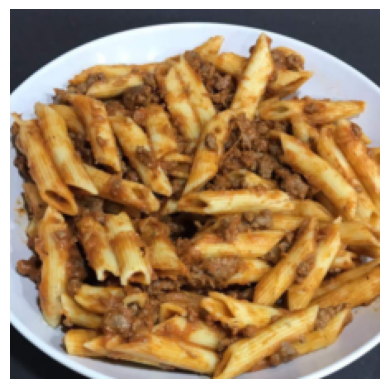

RECIPE 1

Title: Pasta with caramelized onions

Ingredients:
cheese, pasta, pepper, onion, oil

Instructions:
-Heat oil in a large skillet over medium heat.
-Add onions and cook, stirring occasionally, until golden brown, about 20 minutes.
-Add salt and pepper to taste.
-Cook, stirring occasionally, until onions are golden brown, about 20 minutes.
-Meanwhile, cook pasta according to package directions.
-Drain pasta and toss with onions and cheese.
RECIPE 2

Title: Penne with caramelized onions

Ingredients:
cheese, pasta, pepper, onion, oil

Instructions:
-Preheat broiler.
-In large bowl, add olive oil, salt and pepper, and stir to combine.
-Add onions and stir to coat.
-Spread onions on foil-lined baking sheet and put in oven.
-Cook, without turning, 20 minutes.
-Add water to pan if dry.
-Cook until onions are golden brown, 15 minutes.
-Add pasta and toss.
-Sprinkle with cheese and broil until melted.
-Makes 6 servings.
RECIPE 2

Title: Penne with caramelized onions

Ingredients:
chee

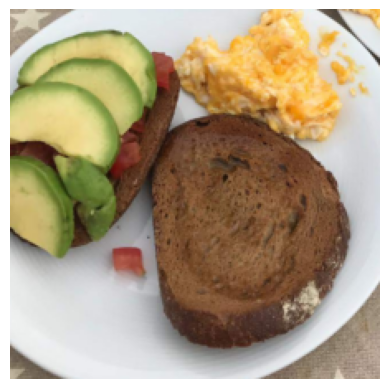

RECIPE 1

Title: Avocado egg salad sandwich

Ingredients:
avocado, bread, tomato, mayonnaise, pepper, egg, salt

Instructions:
-Toast bread.
-Spread with mayonnaise.
-Top with tomato, avocado and egg.
-Sprinkle with salt and pepper.
RECIPE 2

Title: Egg in avocado toast

Ingredients:
avocado, bread, tomato, mayonnaise, pepper, egg, salt

Instructions:
-Toast bread.
-Spread avocado on toast then mayo.
-Put the egg on top of the avocado.
-Salt and pepper to taste.
RECIPE 2

Title: Egg in avocado toast

Ingredients:
avocado, bread, tomato, mayonnaise, pepper, egg, salt

Instructions:
-Toast bread.
-Spread avocado on toast then mayo.
-Put the egg on top of the avocado.
-Salt and pepper to taste.
RECIPE 3

Title: Egg salad sandwich (ww)

Ingredients:
avocado, bread, tomato, mayonnaise, pepper, egg, salt

Instructions:
-Place the egg in a medium bowl; add salt and pepper.
-Stir gently until well mixed.
-Spoon the salad onto 4 slices of bread.
-Top with tomato and top with remaining slices of

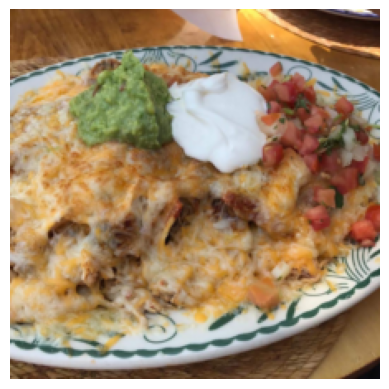

RECIPE 1

Title: Chicken enchilada casserole

Ingredients:
cheese, tortilla, onion, cream, enchilada_sauce, chicken, chili, beans, pepper, tomato, cumin

Instructions:
-Preheat oven to 350 degrees.
-In a large skillet, saute onion in oil until tender.
-Add chicken, beans, tomatoes, enchilada sauce, cumin, chili powder and salt and pepper to taste.
-Simmer for 10 minutes.
-In a 9x13 baking dish, layer 1/2 of the enchilada sauce, 1/2 of the chicken mixture, 1/2 of the cheese, 1/2 of the sour cream, 1/2 of the remaining enchilada sauce, and 1/2 of the cheese.
-Repeat layers.
-Bake for 30 minutes.
RECIPE 2

Title: Chicken enchiladas

Ingredients:
cheese, tortilla, onion, cream, enchilada_sauce, chicken, chili, beans, pepper, tomato, cumin

Instructions:
-Preheat oven to 350 degrees.
-Spray a 9 x 13 baking dish with olive oil spray.
-Spread a layer of refried beans, then top with chicken, then a layer of tomato sauce and then a layer of cheese.
-Repeat layers once more ending with cheese.
-

In [57]:
import os
from io import BytesIO
import requests
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision import transforms

# Allowed image extensions
valid_exts = ('.jpg', '.jpeg', '.png', '.bmp')

for img_file in demo_files:
    
    # 🚫 Skip hidden files and non-image files (e.g., .DS_Store)
    if img_file.startswith('.') or (not img_file.lower().endswith(valid_exts)):
        continue
    
    if use_urls:
        response = requests.get(img_file)
        image = Image.open(BytesIO(response.content))
    else:
        image_path = os.path.join(image_folder, img_file)
        image = Image.open(image_path).convert('RGB')
    
    transf_list = []
    transf_list.append(transforms.Resize(256))
    transf_list.append(transforms.CenterCrop(224))
    transform = transforms.Compose(transf_list)
    
    image_transf = transform(image)
    image_tensor = to_input_transf(image_transf).unsqueeze(0).to(device)
    
    plt.imshow(image_transf)
    plt.axis('off')
    plt.show()
    plt.close()
    
    num_valid = 1
    for i in range(numgens):
        with torch.no_grad():
            outputs = model.sample(
                image_tensor,
                greedy=greedy[i], 
                temperature=temperature,
                beam=beam[i],
                true_ingrs=None
            )
            
        ingr_ids = outputs['ingr_ids'].cpu().numpy()
        recipe_ids = outputs['recipe_ids'].cpu().numpy()
            
        outs, valid = prepare_output(recipe_ids[0], ingr_ids[0], ingrs_vocab, vocab)
        
        if valid['is_valid'] or show_anyways:
            
            print('RECIPE', num_valid)
            num_valid += 1
    
            BOLD = '\033[1m'
            END = '\033[0m'
            print(BOLD + '\nTitle:' + END, outs['title'])

            print(BOLD + '\nIngredients:' + END)
            print(', '.join(outs['ingrs']))

            print(BOLD + '\nInstructions:' + END)
            print('-' + '\n-'.join(outs['recipe']))

            print('=' * 20)

        else:
            print("Not a valid recipe!")
            print("Reason: ", valid['reason'])

In [58]:
# ============================================
# Ingredient Replacement: Find replaceable ingredients based on Embedding Similarity
# ============================================

import torch.nn.functional as F

def find_ingredient_replacements(missing_ingredient, ingrs_vocab, model, top_k=5, exclude_ingredients=None):
    """
    Find replaceable ingredients based on embedding similarity
    
    Args:
        missing_ingredient: Name of the missing ingredient (str)
        ingrs_vocab: List of ingredient vocabulary
        model: Trained model
        top_k: Return top k most similar ingredients
        exclude_ingredients: List of ingredients to exclude (e.g., those already in the recipe)
    
    Returns:
        replacements: List of tuples (ingredient_name, similarity_score)
    """
    # Create mapping from ingredient name to index
    ingr_name_to_idx = {name: idx for idx, name in enumerate(ingrs_vocab)}
    
    # Check if ingredient is in vocabulary
    if missing_ingredient not in ingr_name_to_idx:
        # Try lowercase matching
        missing_ingredient_lower = missing_ingredient.lower()
        found = False
        for name, idx in ingr_name_to_idx.items():
            if name.lower() == missing_ingredient_lower:
                missing_ingredient = name
                found = True
                break
        if not found:
            return None, f"Ingredient '{missing_ingredient}' not in vocabulary"
    
    # Get index of missing ingredient
    missing_idx = ingr_name_to_idx[missing_ingredient]
    
    # Get embedding weights (shape: [vocab_size, embed_size])
    # model.ingredient_encoder.linear is nn.Embedding layer
    embeddings = model.ingredient_encoder.linear.weight.data  # [vocab_size, embed_size]
    
    # Get embedding of missing ingredient
    missing_embedding = embeddings[missing_idx]  # [embed_size]
    
    # Calculate cosine similarity with all ingredients
    # Normalize embeddings
    embeddings_norm = F.normalize(embeddings, p=2, dim=1)  # [vocab_size, embed_size]
    missing_embedding_norm = F.normalize(missing_embedding.unsqueeze(0), p=2, dim=1)  # [1, embed_size]
    
    # Calculate cosine similarity
    similarities = torch.mm(missing_embedding_norm, embeddings_norm.t()).squeeze(0)  # [vocab_size]
    
    # Exclude special tokens (<end>, <pad>) and the missing ingredient itself
    exclude_indices = [0, len(ingrs_vocab)-1, missing_idx]  # <end> is usually 0, <pad> is usually last
    
    # If exclude list provided, exclude them too
    if exclude_ingredients:
        for ingr in exclude_ingredients:
            if ingr in ingr_name_to_idx:
                exclude_indices.append(ingr_name_to_idx[ingr])
    
    # Set similarity of excluded indices to -1
    similarities[exclude_indices] = -1
    
    # Get top_k most similar ingredients
    top_similarities, top_indices = torch.topk(similarities, min(top_k + len(exclude_indices), len(similarities)))
    
    # Filter out excluded ingredients
    replacements = []
    for sim, idx in zip(top_similarities, top_indices):
        if idx.item() not in exclude_indices and sim.item() > -1:
            ingr_name = ingrs_vocab[idx.item()]
            replacements.append((ingr_name, sim.item()))
            if len(replacements) >= top_k:
                break
    
    return replacements, None

# Test function
def print_replacements(missing_ingredient, ingrs_vocab, model, top_k=5, exclude_ingredients=None):
    """Print replacement suggestions"""
    replacements, error = find_ingredient_replacements(
        missing_ingredient, ingrs_vocab, model, top_k, exclude_ingredients
    )
    
    if error:
        print(f"❌ Error: {error}")
        return
    
    if not replacements:
        print(f"❌ No replacements found for '{missing_ingredient}'")
        return
    
    print(f"\n🔍 Replacements found for '{missing_ingredient}' (based on Embedding Similarity):")
    print("=" * 60)
    for i, (ingr_name, similarity) in enumerate(replacements, 1):
        print(f"{i}. {ingr_name:30s} (Similarity: {similarity:.4f})")
    print("=" * 60)
    
    return replacements

print("✅ Ingredient replacement function loaded!")
print("Usage example: print_replacements('onion', ingrs_vocab, model, top_k=5)")

✅ Ingredient replacement function loaded!
Usage example: print_replacements('onion', ingrs_vocab, model, top_k=5)


In [59]:
# ============================================
# Interactive Menu Generation and Ingredient Replacement
# ============================================

# Global variable: store currently generated recipes
current_recipes = []  # Store all generated recipes

def generate_recipes_interactive(image_path_or_url, model, ingrs_vocab, vocab, 
                                device, to_input_transf, greedy=[True, False, False, False],
                                beam=[-1, -1, -1, -1], temperature=1.0, use_urls=False):
    """
    Generate recipes and save results, supporting subsequent interactive queries
    
    Args:
        image_path_or_url: Image path or URL
        model: Trained model
        ingrs_vocab: Ingredient vocabulary
        vocab: Recipe vocabulary
        device: Device
        to_input_transf: Image preprocessing
        greedy, beam, temperature: Generation parameters
        use_urls: Whether to use URL
    
    Returns:
        recipes: List of generated recipes
    """
    global current_recipes
    current_recipes = []
    
    # Load image
    if use_urls:
        response = requests.get(image_path_or_url)
        image = Image.open(BytesIO(response.content))
    else:
        image = Image.open(image_path_or_url).convert('RGB')
    
    # Preprocess image
    transf_list = []
    transf_list.append(transforms.Resize(256))
    transf_list.append(transforms.CenterCrop(224))
    transform = transforms.Compose(transf_list)
    
    image_transf = transform(image)
    image_tensor = to_input_transf(image_transf).unsqueeze(0).to(device)
    
    # Show image
    plt.imshow(image_transf)
    plt.axis('off')
    plt.show()
    plt.close()
    
    # Generate multiple recipes
    num_valid = 1
    numgens = len(greedy)
    
    for i in range(numgens):
        with torch.no_grad():
            outputs = model.sample(
                image_tensor,
                greedy=greedy[i], 
                temperature=temperature,
                beam=beam[i],
                true_ingrs=None
            )
            
        ingr_ids = outputs['ingr_ids'].cpu().numpy()
        recipe_ids = outputs['recipe_ids'].cpu().numpy()
            
        outs, valid = prepare_output(recipe_ids[0], ingr_ids[0], ingrs_vocab, vocab)
        
        if valid['is_valid']:
            recipe_info = {
                'recipe_num': num_valid,
                'title': outs['title'],
                'ingredients': outs['ingrs'],
                'instructions': outs['recipe'],
                'valid': valid
            }
            current_recipes.append(recipe_info)
            
            # Print recipe
            BOLD = '\033[1m'
            END = '\033[0m'
            print(f'RECIPE {num_valid}')
            print(BOLD + '\nTitle:' + END, outs['title'])
            print(BOLD + '\nIngredients:' + END)
            print(', '.join(outs['ingrs']))
            print(BOLD + '\nInstructions:' + END)
            print('-' + '\n-'.join(outs['recipe']))
            print('=' * 20)
            
            num_valid += 1
    
    print(f"\n✅ Generated {len(current_recipes)} valid recipes")
    return current_recipes

def ask_for_replacement(recipe_num, missing_ingredient, ingrs_vocab, model, top_k=5):
    """
    Interactive query: If an ingredient is missing, what can replace it?
    
    Args:
        recipe_num: Recipe number (starting from 1)
        missing_ingredient: Name of the missing ingredient
        ingrs_vocab: Ingredient vocabulary
        model: Trained model
        top_k: Return top k most similar ingredients
    
    Returns:
        replacements: List of replacement suggestions
    """
    global current_recipes
    
    if not current_recipes:
        print("❌ Error: No recipes generated yet. Please run generate_recipes_interactive() first.")
        return None
    
    if recipe_num < 1 or recipe_num > len(current_recipes):
        print(f"❌ Error: Recipe number {recipe_num} does not exist. Please choose 1-{len(current_recipes)}")
        return None
    
    # Get selected recipe
    selected_recipe = current_recipes[recipe_num - 1]
    selected_ingredients = selected_recipe['ingredients']
    
    # Check if missing ingredient is in the recipe
    if missing_ingredient not in selected_ingredients:
        print(f"⚠️  Warning: '{missing_ingredient}' is not in recipe {recipe_num}")
        print(f"   Ingredients in recipe {recipe_num}: {', '.join(selected_ingredients)}")
        print("   Do you still want to find replacements? (y/n): ", end='')
        # In notebook, we can continue directly but give a hint
        print("(Continuing to find replacements...)")
    
    # Call replacement function
    print(f"\n🔍 Finding replacements for '{missing_ingredient}' in recipe {recipe_num}...")
    print(f"📋 Recipe Title: {selected_recipe['title']}")
    print(f"📋 Current Ingredients: {', '.join(selected_ingredients)}")
    print()
    
    # Exclude other ingredients already in the recipe (avoid recommending duplicates)
    exclude_list = [ingr for ingr in selected_ingredients if ingr != missing_ingredient]
    
    # Directly call print_replacements
    replacements = print_replacements(
        missing_ingredient,
        ingrs_vocab,
        model,
        top_k=top_k,
        exclude_ingredients=exclude_list
    )
    
    if replacements:
        print(f"\n💡 Suggestion: You can replace '{missing_ingredient}' with the above ingredients")
        print("   Higher similarity usually means better replacement")
    
    return replacements

# Convenience function: Quick query
def what_can_replace(recipe_num, missing_ingredient, top_k=5):
    """
    Quick query function: If XX is missing, what can replace it?
    
    Usage example:
        what_can_replace(1, 'onion', top_k=5)
    """
    return ask_for_replacement(recipe_num, missing_ingredient, ingrs_vocab, model, top_k)

# Simplified function: Automatically use global variables, only need image path
def generate_from_image(image_path_or_url, use_urls=False):
    """
    Simplified recipe generation: Only need image path
    
    Args:
        image_path_or_url: Image path or URL
        use_urls: Whether to use URL (default False)
    
    Example:
        generate_from_image('pizza.jpg')
        generate_from_image('https://example.com/food.jpg', use_urls=True)
    """
    return generate_recipes_interactive(
        image_path_or_url, model, ingrs_vocab, vocab, 
        device, to_input_transf, use_urls=use_urls
    )

print("✅ Interactive recipe generation and replacement function loaded!")
print("\n" + "="*70)
print("📖 Full Usage Flow (3 Steps):")
print("="*70)
print("\n【Step 1】Generate Recipe (Two Ways):")
print("  ✅ Simple Way: generate_from_image('image_path.jpg')")
print("  📝 Full Way: generate_recipes_interactive('image_path', model, ingrs_vocab, vocab, device, to_input_transf)")
print("\n【Step 2】View generated recipes, choose the one you like (e.g., Recipe 1)")
print("\n【Step 3】Ask for Replacement:")
print("  what_can_replace(1, 'onion')  # Recipe 1 is missing onion, what can replace it?")
print("  what_can_replace(1, 'cheese', top_k=3)  # Return 3 replacement options")
print("\n" + "="*70)
print("\n💡 Practical Example:")
print("  # 1. Generate Recipe")
print("  generate_from_image(os.path.join(data_dir, 'demo_imgs', 'pizza.jpg'))")
print("  # 2. View Recipe, assume Recipe 1 is selected")
print("  # 3. Missing onion, ask for replacement")
print("  what_can_replace(1, 'onion')")
print("="*70)

✅ Interactive recipe generation and replacement function loaded!

📖 Full Usage Flow (3 Steps):

【Step 1】Generate Recipe (Two Ways):
  ✅ Simple Way: generate_from_image('image_path.jpg')
  📝 Full Way: generate_recipes_interactive('image_path', model, ingrs_vocab, vocab, device, to_input_transf)

【Step 2】View generated recipes, choose the one you like (e.g., Recipe 1)

【Step 3】Ask for Replacement:
  what_can_replace(1, 'onion')  # Recipe 1 is missing onion, what can replace it?
  what_can_replace(1, 'cheese', top_k=3)  # Return 3 replacement options


💡 Practical Example:
  # 1. Generate Recipe
  generate_from_image(os.path.join(data_dir, 'demo_imgs', 'pizza.jpg'))
  # 2. View Recipe, assume Recipe 1 is selected
  # 3. Missing onion, ask for replacement
  what_can_replace(1, 'onion')


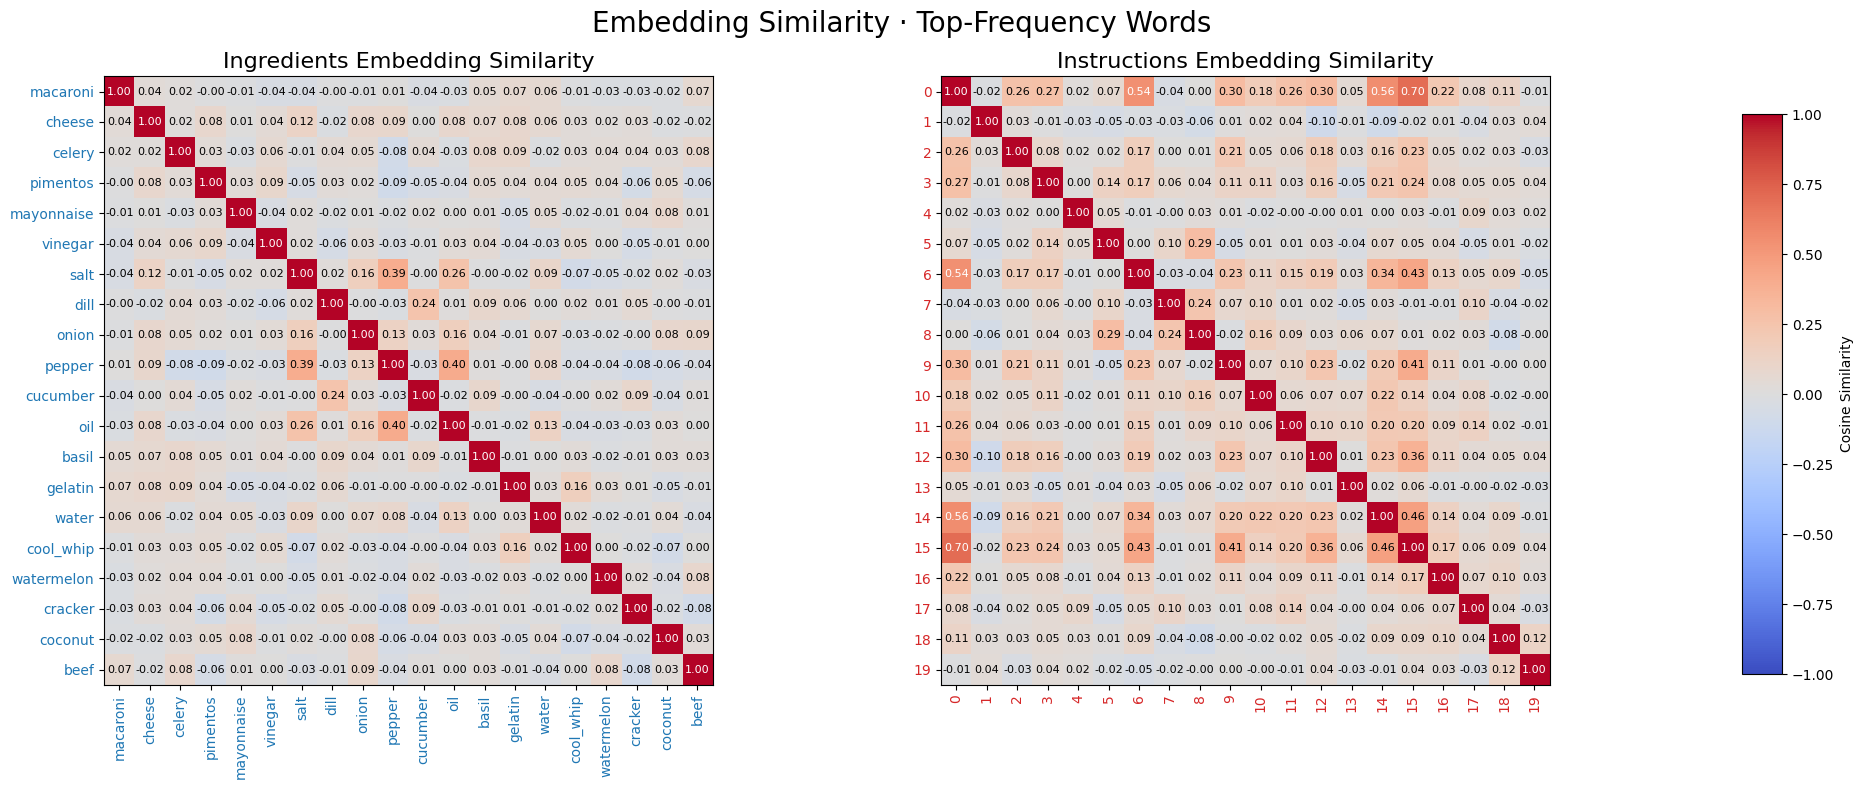

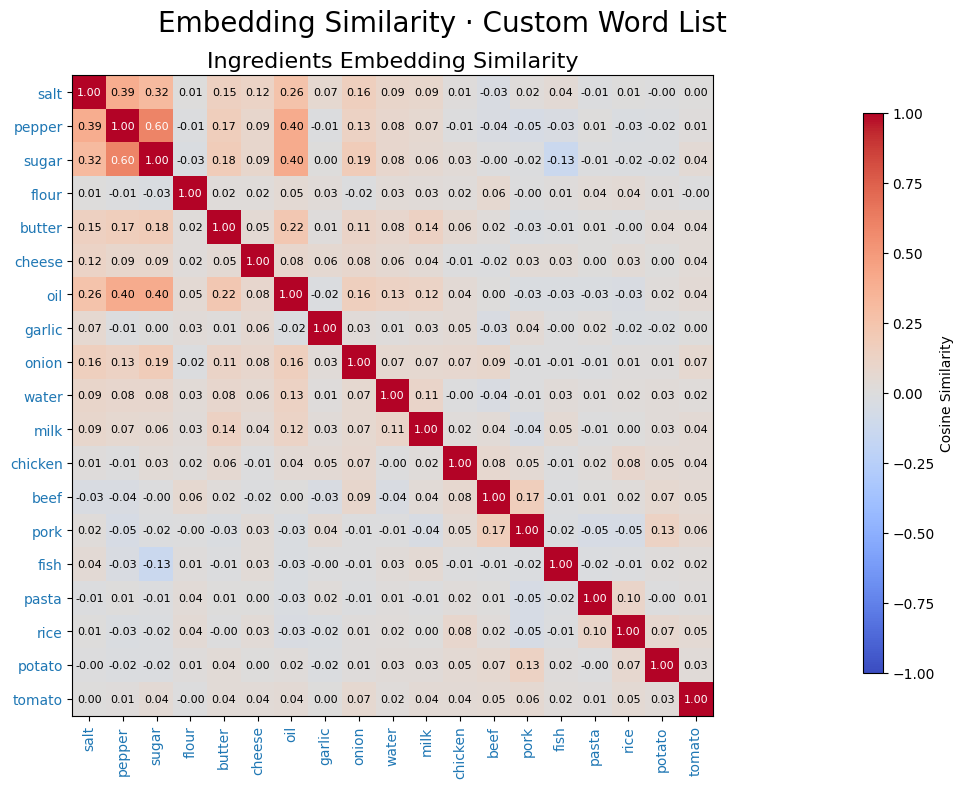

In [60]:
# =================================================================
# Embedding Similarity Heatmap: Common Words & Custom Words Comparison (Fixed Layout)
# =================================================================

import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

def select_top_words(vocab_list, top_n, skip_tokens=None):
    """Select top_n most common words from vocabulary, skipping special tokens."""
    skip_tokens = set(skip_tokens or [])
    return [w for w in vocab_list if w not in skip_tokens][:top_n]

def prepare_vectors(words_by_type):
    """Map words to embedding vectors and split by type."""
    ingredient_matrix = model.ingredient_encoder.linear.weight.data.cpu().numpy()
    instruction_matrix = model.recipe_decoder.embed_tokens.weight.data.cpu().numpy()
    ingredient_lookup = {word: idx for idx, word in enumerate(ingrs_vocab)}
    instruction_lookup = {word: idx for idx, word in enumerate(vocab)}

    ingredient_words = [word for word in words_by_type['ingredient'] if word in ingredient_lookup]
    instruction_words = [word for word in words_by_type['instruction'] if word in instruction_lookup]

    ingredient_vectors = (
        np.stack([ingredient_matrix[ingredient_lookup[word]] for word in ingredient_words])
        if ingredient_words else np.empty((0, ingredient_matrix.shape[1]))
    )
    instruction_vectors = (
        np.stack([instruction_matrix[instruction_lookup[word]] for word in instruction_words])
        if instruction_words else np.empty((0, instruction_matrix.shape[1]))
    )
    return ingredient_words, ingredient_vectors, instruction_words, instruction_vectors

def plot_similarity_panels(words_by_type, title_suffix):
    """Plot split heatmaps, two columns for ingredients and instructions respectively."""
    ingredient_words, ingredient_vectors, instruction_words, instruction_vectors = prepare_vectors(words_by_type)

    # Check if there are enough words to plot
    has_ingr = len(ingredient_words) >= 2
    has_instr = len(instruction_words) >= 2

    if not has_ingr and not has_instr:
        print(f"[{title_suffix}] Not enough valid words for visualization.")
        return

    # Dynamically decide number of subplots: if instruction words are too few, only plot ingredients
    if has_ingr and has_instr:
        fig, axes = plt.subplots(1, 2, figsize=(20, 8))
        plots = [
            ('Ingredients Embedding Similarity', ingredient_words, ingredient_vectors, axes[0], 'tab:blue'),
            ('Instructions Embedding Similarity', instruction_words, instruction_vectors, axes[1], 'tab:red')
        ]
    elif has_ingr:
        fig, axes = plt.subplots(1, 1, figsize=(10, 8))
        axes = [axes] # Convert to list for unified processing
        plots = [
            ('Ingredients Embedding Similarity', ingredient_words, ingredient_vectors, axes[0], 'tab:blue')
        ]
    else:
        # Only instruction words (rare case)
        fig, axes = plt.subplots(1, 1, figsize=(10, 8))
        axes = [axes]
        plots = [
            ('Instructions Embedding Similarity', instruction_words, instruction_vectors, axes[0], 'tab:red')
        ]

    fig.suptitle(f"Embedding Similarity · {title_suffix}", fontsize=20, y=0.98)

    heatmaps = []
    for title, labels, vectors, ax, color in plots:
        similarity_matrix = cosine_similarity(vectors)
        im = ax.imshow(similarity_matrix, cmap='coolwarm', vmin=-1, vmax=1)
        heatmaps.append(im)

        # Set axes
        ax.set_xticks(np.arange(len(labels)))
        ax.set_yticks(np.arange(len(labels)))
        ax.set_xticklabels(labels, rotation=90, color=color, fontsize=10)
        ax.set_yticklabels(labels, color=color, fontsize=10)
        ax.set_title(title, fontsize=16)

        # Show values in grid (if not too many words)
        if len(labels) <= 20:
            for i in range(len(labels)):
                for j in range(len(labels)):
                    text_color = 'white' if abs(similarity_matrix[i, j]) > 0.5 else 'black'
                    ax.text(j, i, f"{similarity_matrix[i, j]:.2f}", ha='center', va='center',
                            color=text_color, fontsize=8)

    # --- Key Fix: Manually Add Colorbar ---
    # rect=[left, bottom, right, top]: Reserve 10% space on the right for colorbar
    plt.tight_layout(rect=[0, 0, 0.9, 1])
    
    # Manually add an axis in the reserved area on the right [left, bottom, width, height]
    cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    fig.colorbar(heatmaps[0], cax=cax, label='Cosine Similarity')

    plt.show()

# 1) Common Words (Select top_n from vocabulary)
common_words_by_type = {
    'ingredient': select_top_words(ingrs_vocab, top_n=20, skip_tokens={'<pad>', '<end>'}),
    'instruction': select_top_words(vocab, top_n=20, skip_tokens={'<pad>', '<end>', '<bos>', '<unk>'})
}
plot_similarity_panels(common_words_by_type, title_suffix="Top-Frequency Words")

# 2) Custom Words (Modify list as needed)
custom_words_by_type = {
    'ingredient': [
        'salt', 'pepper', 'sugar', 'flour', 'butter', 'cheese', 'oil', 'garlic', 'onion',
        'water', 'milk', 'chicken', 'beef', 'pork', 'fish', 'pasta', 'rice', 'potato', 'tomato'
    ],
    'instruction': [
        'bake', 'fry', 'roast', 'boil', 'chop', 'mix', 'stir', 'slice', 'preheat', 'serve',
        'add', 'cook', 'heat', 'place', 'remove', 'drain', 'season', 'combine'
    ]
}
plot_similarity_panels(custom_words_by_type, title_suffix="Custom Word List")

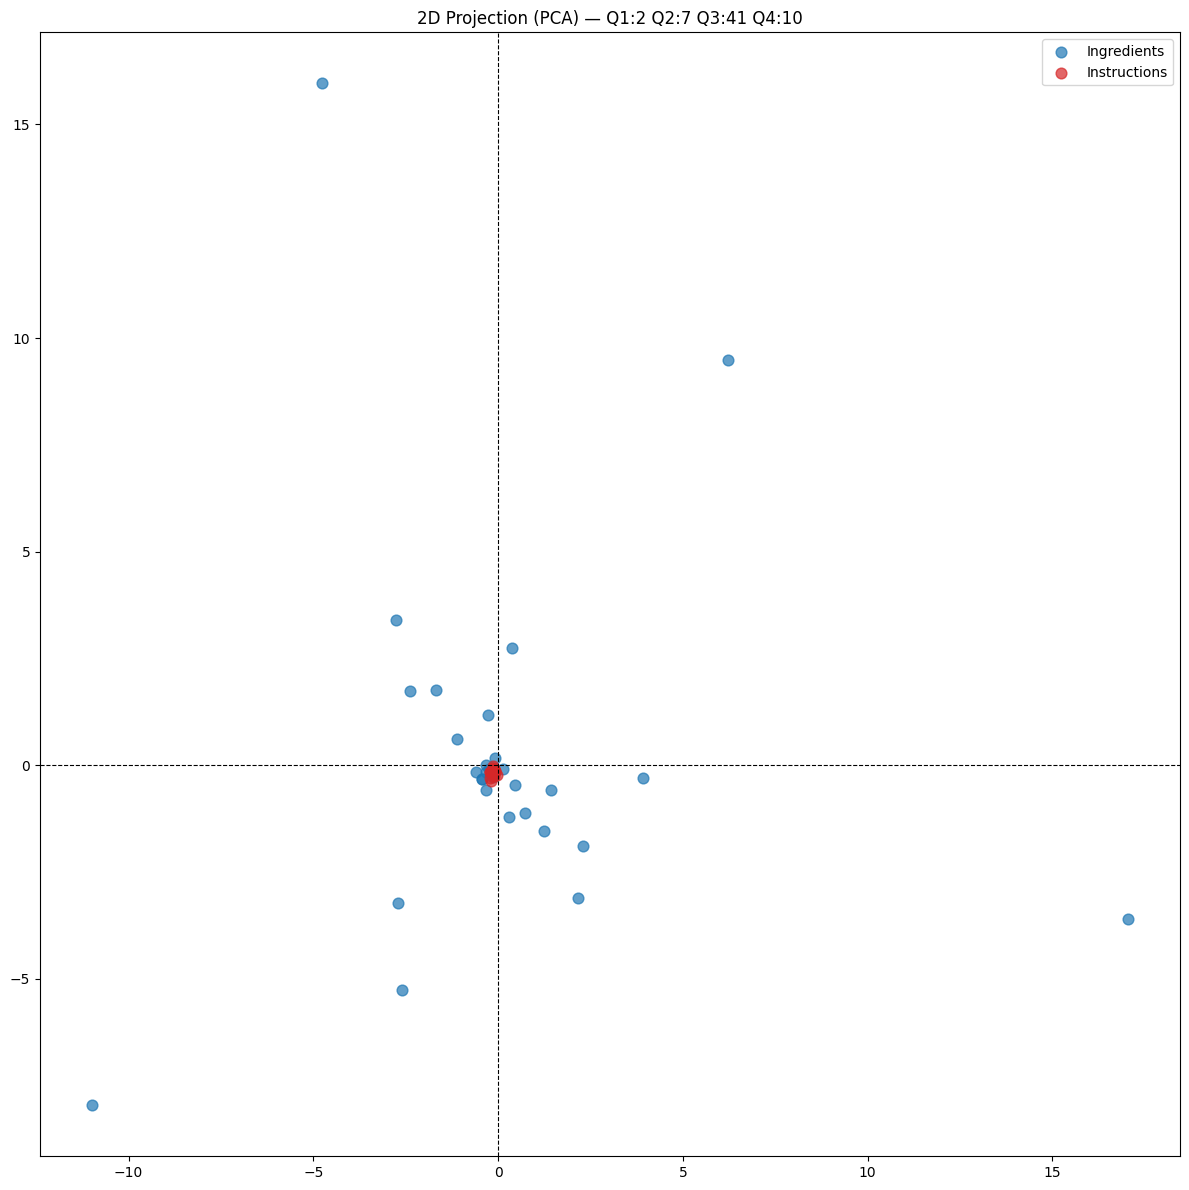

In [61]:
# =================================================================
# 2D Projection Scatter Plot (Quadrants): PCA / t-SNE (Common or Custom Words)
# =================================================================

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def get_vocab_list(vocab_obj):
    """Helper function: Ensure getting a list of words. If dict (idx->word), convert to list sorted by index."""
    if isinstance(vocab_obj, dict):
        # Assume idx -> word dict, sort by key (idx) and take value (word)
        return [vocab_obj[k] for k in sorted(vocab_obj.keys())]
    return vocab_obj

def select_top_words(vocab_obj, top_n, skip_tokens=None):
    vocab_list = get_vocab_list(vocab_obj)
    skip_tokens = set(skip_tokens or [])
    return [w for w in vocab_list if w not in skip_tokens][:top_n]

def prepare_vectors(words_by_type):
    """Map words to embedding vectors and split by type."""
    # Check global variables
    if 'ingrs_vocab' not in globals() or 'vocab' not in globals() or 'model' not in globals():
        raise NameError("Global variables 'ingrs_vocab', 'vocab', or 'model' not defined.")

    # Ensure getting word list (strings), not dict
    ingr_list = get_vocab_list(ingrs_vocab)
    instr_list = get_vocab_list(vocab)

    ingredient_matrix = model.ingredient_encoder.linear.weight.data.cpu().numpy()
    instruction_matrix = model.recipe_decoder.embed_tokens.weight.data.cpu().numpy()
    
    # Build word -> matrix_index mapping
    ingredient_lookup = {word: idx for idx, word in enumerate(ingr_list)}
    instruction_lookup = {word: idx for idx, word in enumerate(instr_list)}

    ingredient_words = [word for word in words_by_type['ingredient'] if word in ingredient_lookup]
    instruction_words = [word for word in words_by_type['instruction'] if word in instruction_lookup]

    ingredient_vectors = (
        np.stack([ingredient_matrix[ingredient_lookup[word]] for word in ingredient_words])
        if ingredient_words else np.empty((0, ingredient_matrix.shape[1]))
    )
    instruction_vectors = (
        np.stack([instruction_matrix[instruction_lookup[word]] for word in instruction_words])
        if instruction_words else np.empty((0, instruction_matrix.shape[1]))
    )
    return ingredient_words, ingredient_vectors, instruction_words, instruction_vectors

def plot_2d_quadrants(use_common=True, top_n=50, method='pca', words_by_type_input=None, annotate_limit=200):
    """
    Project embeddings to 2D and plot quadrant scatter plot.
    - use_common: True to use top_n common words from vocab; False to use custom word list from words_by_type_input.
    - method: 'pca' or 'tsne'
    - annotate_limit: Label words if number of points <= annotate_limit.
    """
    # Safety check: Ensure global variables exist
    if 'ingrs_vocab' not in globals() or 'vocab' not in globals():
        print("❌ Error: Global variables 'ingrs_vocab' or 'vocab' not found.")
        print("   Please run previous cells to load data and model.")
        return

    if use_common:
        skip_ing = {'<pad>', '<end>'}
        skip_instr = {'<pad>', '<end>', '<bos>', '<unk>'}
        words_by_type = {
            'ingredient': select_top_words(ingrs_vocab, top_n=top_n, skip_tokens=skip_ing),
            'instruction': select_top_words(vocab, top_n=top_n, skip_tokens=skip_instr)
        }
    else:
        if words_by_type_input is None:
            print("Please provide custom word list: words_by_type_input")
            return
        words_by_type = words_by_type_input

    try:
        ingr_words, ingr_vecs, instr_words, instr_vecs = prepare_vectors(words_by_type)
    except NameError as e:
        print(f"❌ Error: {e}")
        return

    words = list(ingr_words) + list(instr_words)
    
    if len(words) < 2:
        print('Not enough valid words to plot 2D scatter.')
        return

    # Merge vectors
    if ingr_vecs.size == 0:
        X = instr_vecs
    elif instr_vecs.size == 0:
        X = ingr_vecs
    else:
        X = np.vstack([ingr_vecs, instr_vecs])

    # Dimensionality Reduction
    method = method.lower()
    if method == 'pca':
        reducer = PCA(n_components=2)
        X2 = reducer.fit_transform(X)
    elif method == 'tsne':
        perp = min(30, max(5, X.shape[0] // 3))
        reducer = TSNE(n_components=2, perplexity=perp, random_state=0, init='pca', learning_rate='auto', n_iter=1000)
        X2 = reducer.fit_transform(X)
    else:
        raise ValueError("method must be 'pca' or 'tsne'")

    # Center (make origin more comparable)
    X2 = X2 - X2.mean(axis=0)

    # Plotting
    fig, ax = plt.subplots(figsize=(12, 12))
    n_ing = len(ingr_words)
    if n_ing > 0:
        ax.scatter(X2[:n_ing, 0], X2[:n_ing, 1], c='tab:blue', label='Ingredients', alpha=0.7, s=60)
    if len(instr_words) > 0:
        ax.scatter(X2[n_ing:, 0], X2[n_ing:, 1], c='tab:red', label='Instructions', alpha=0.7, s=60)

    # Quadrant reference lines
    ax.axhline(0, color='k', linewidth=0.8, linestyle='--')
    ax.axvline(0, color='k', linewidth=0.8, linestyle='--')

    # Annotation (Removed)
    # if len(words) <= annotate_limit:
    #     for i, w in enumerate(words):
    #         # Ensure w is string
    #         label_text = str(w)
    #         ax.text(X2[i, 0], X2[i, 1], ' ' + label_text, fontsize=10, alpha=0.8, va='bottom', ha='left')

    # Count points in each quadrant
    x_pos = X2[:, 0] > 0
    y_pos = X2[:, 1] > 0
    q1 = np.sum(x_pos & y_pos)
    q2 = np.sum(~x_pos & y_pos)
    q3 = np.sum(~x_pos & ~y_pos)
    q4 = np.sum(x_pos & ~y_pos)

    ax.set_title(f"2D Projection ({method.upper()}) — Q1:{q1} Q2:{q2} Q3:{q3} Q4:{q4}")
    ax.legend()
    plt.tight_layout()
    plt.show()

# Example: Common Words (PCA)
try:
    plot_2d_quadrants(use_common=True, top_n=30, method='pca', annotate_limit=200)
except Exception as e:
    print(f"Cannot run example: {e}")
    print("Hint: Please ensure previous cells are run to load model, ingrs_vocab and vocab.")

# Example: Custom Words (t-SNE)
# plot_2d_quadrants(use_common=False, method='tsne', words_by_type_input=custom_words_by_type)

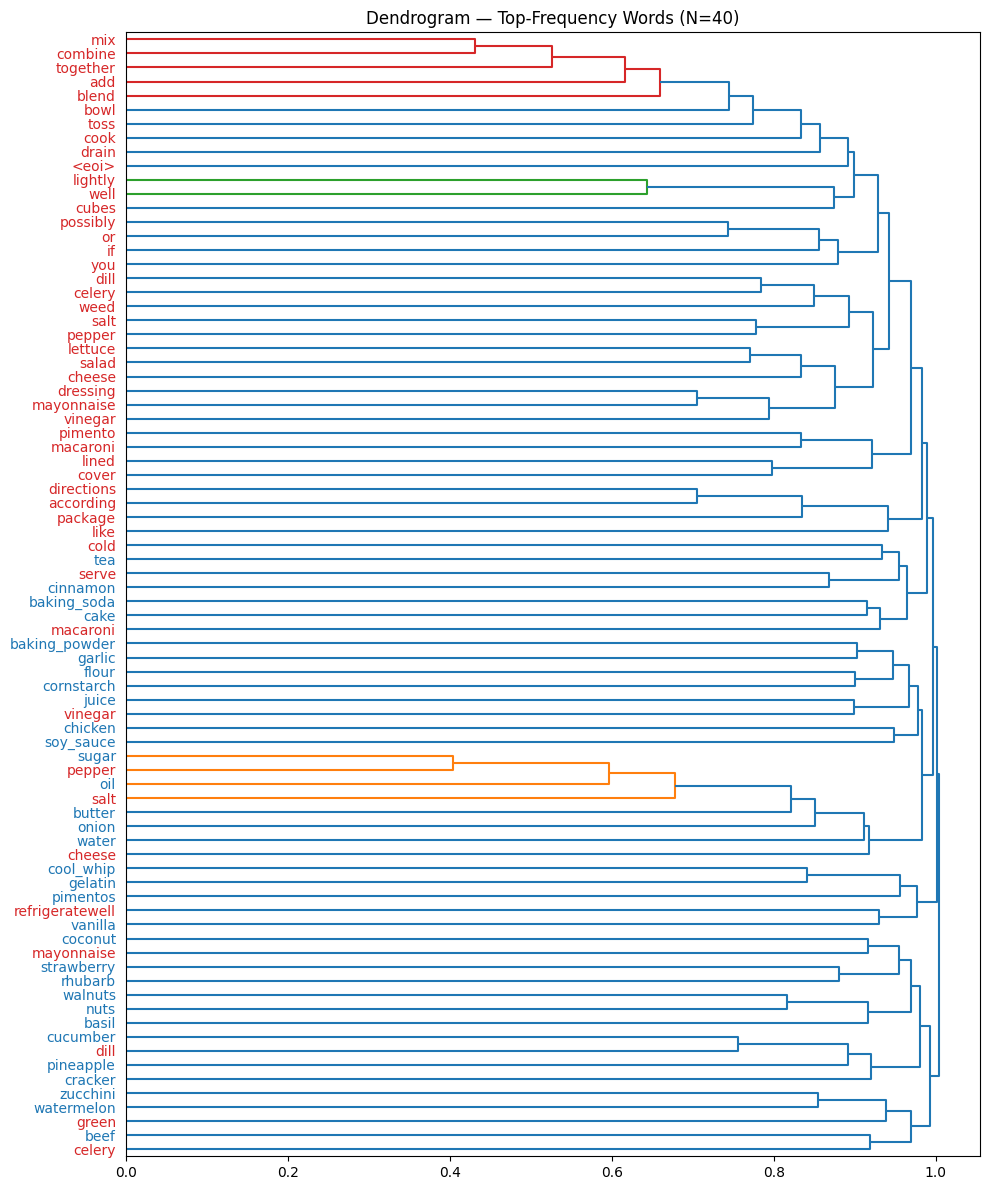

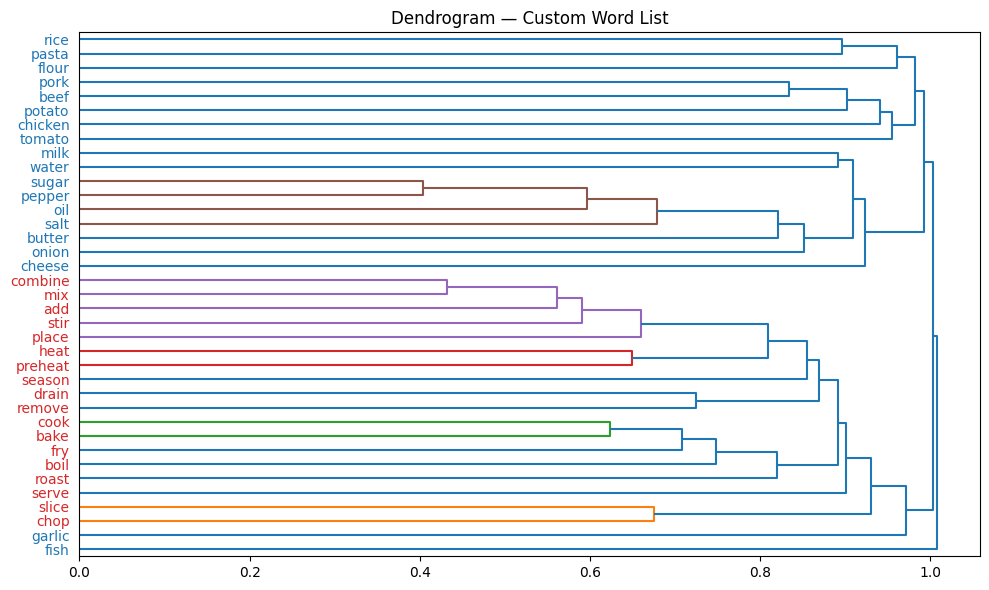

In [62]:
# =================================================================
# Dendrogram Visualization: Display hierarchical relationships between word vectors
# =================================================================

from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt
import numpy as np

def get_vocab_list(vocab_obj):
    """Helper function: Ensure getting a list of words. If dict (idx->word), convert to list sorted by index."""
    if isinstance(vocab_obj, dict):
        return [vocab_obj[k] for k in sorted(vocab_obj.keys())]
    return vocab_obj

def prepare_vectors(words_by_type):
    """Same as above: Map words to embedding vectors and split by type."""
    # Key fix: Ensure using list format for vocabulary
    ingr_list = get_vocab_list(ingrs_vocab)
    instr_list = get_vocab_list(vocab)

    ingredient_matrix = model.ingredient_encoder.linear.weight.data.cpu().numpy()
    instruction_matrix = model.recipe_decoder.embed_tokens.weight.data.cpu().numpy()
    
    ingredient_lookup = {word: idx for idx, word in enumerate(ingr_list)}
    instruction_lookup = {word: idx for idx, word in enumerate(instr_list)}

    ingredient_words = [word for word in words_by_type['ingredient'] if word in ingredient_lookup]
    instruction_words = [word for word in words_by_type['instruction'] if word in instruction_lookup]

    ingredient_vectors = (
        np.stack([ingredient_matrix[ingredient_lookup[word]] for word in ingredient_words])
        if ingredient_words else np.empty((0, ingredient_matrix.shape[1]))
    )
    instruction_vectors = (
        np.stack([instruction_matrix[instruction_lookup[word]] for word in instruction_words])
        if instruction_words else np.empty((0, instruction_matrix.shape[1]))
    )
    return ingredient_words, ingredient_vectors, instruction_words, instruction_vectors

def plot_dendrogram(words_by_type, title_suffix='', metric='cosine', method='average'):
    """
    Plot dendrogram using hierarchical clustering to show relationships between word vectors.
    - words_by_type: {'ingredient': [...], 'instruction': [...]}
    - metric: Distance metric (supported by pdist), 'cosine' recommended
    - method: linkage method ('average','single','complete',...)
    """
    ingr_words, ingr_vecs, instr_words, instr_vecs = prepare_vectors(words_by_type)
    words = list(ingr_words) + list(instr_words)
    # Ensure labels are strings
    words = [str(w) for w in words]
    
    types = ['ingredient'] * len(ingr_words) + ['instruction'] * len(instr_words)

    if len(words) < 2:
        print('Not enough valid words to plot dendrogram.')
        return

    if ingr_vecs.size == 0:
        X = instr_vecs
    elif instr_vecs.size == 0:
        X = ingr_vecs
    else:
        X = np.vstack([ingr_vecs, instr_vecs])

    try:
        dist_vec = pdist(X, metric)  # pdist with 'cosine' returns 1 - cosine_similarity
        Z = linkage(dist_vec, method=method)
    except Exception as e:
        print('Error calculating clustering/distance:', e)
        return

    fig, ax = plt.subplots(figsize=(10, max(6, 0.15 * len(words))))
    dn = dendrogram(Z, labels=words, orientation='right', leaf_rotation=0, leaf_font_size=10, ax=ax)

    # Color leaf labels by type
    ylabels = ax.get_yticklabels()
    label_to_type = {w: t for w, t in zip(words, types)}
    for lab in ylabels:
        w = lab.get_text()
        t = label_to_type.get(w, None)
        if t == 'ingredient':
            lab.set_color('tab:blue')
        elif t == 'instruction':
            lab.set_color('tab:red')

    ax.set_title(f'Dendrogram — {title_suffix}')
    plt.tight_layout()
    plt.show()

def select_top_words_safe(vocab_obj, top_n, skip_tokens=None):
    vocab_list = get_vocab_list(vocab_obj)
    skip_tokens = set(skip_tokens or [])
    return [w for w in vocab_list if w not in skip_tokens][:top_n]

# 1) Common Words (Top-N) Example
# Define special tokens and stopwords to skip
skip_tokens_list = {
    '<pad>', '<end>', '<bos>', '<unk>', '<start>', 
    '.', ',', ';', ':', '!', '?', 
    'and', 'in', 'the', 'with', 'to', 'of', 'a', 'is', 'it', 'for', 'on'
}

common_words_by_type = {
    'ingredient': select_top_words_safe(ingrs_vocab, top_n=40, skip_tokens=skip_tokens_list),
    'instruction': select_top_words_safe(vocab, top_n=40, skip_tokens=skip_tokens_list)
}
plot_dendrogram(common_words_by_type, title_suffix='Top-Frequency Words (N=40)')

# 2) Custom Words (If custom_words_by_type is defined in notebook)
try:
    plot_dendrogram(custom_words_by_type, title_suffix='Custom Word List')
except NameError:
    print('custom_words_by_type not found; please define it first to plot custom words.')